## 1 - Analysis of the cropped Quotebank dataset

We have filtered out all the rows corresponding to quotes that did not contain any of the keywords related to gun control. The remaining rows have been added to a new file: 'quotes-cropped.json', which will be one of our main datasets for this project. It is much more reasonnable in size (550 Mo) than the full Quotebank dataset. This will allow us to work with Jupyter lab with all the data we need.

In [1]:
#Import usefull libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Disable some pandas warnings we don't need
pd.options.mode.chained_assignment = None

# New dataframe with the data ('quotes-cropped.jspon')
df_original = pd.read_json('quotes-cropped.json', lines=True)

We will start by plotting the number of quotes containing at least one of our keywords over time (i.e. between 2015 and 2020). Even though some quotes will be irrelevant (e.g. "we were **shooting** a movie"), we assume the distribution of these irrelevant quotes to be close to uniform for the moment.

Our plot should therefore give a good first impression on how much people/the media has been speaking about gun control during these five years.

In [2]:
# Keep only the columns that we need for our initial analysis
df = df_original[['date','quotation']]

# Convert data column to datetime format, removing time
df['date'] = pd.to_datetime(df['date'])

# Sort dataframe by date
df = df.sort_values(by=['date'])

df.head()

,date,quotation
65127,2015-01-01 00:07:32,When we are face a suspect holding one of thes...
77653,2015-01-01 00:08:12,I expect much of the same from Edinburgh at Mu...
97745,2015-01-01 00:13:41,Of course the negative is if you need your gun...
45716,2015-01-01 00:13:41,"Me personally, being a mother, when I sell a g..."
79888,2015-01-01 00:14:39,"We had a very good first half, and I thought w..."


Now that we have sorted the dataframe by date, we can move on to the plot.

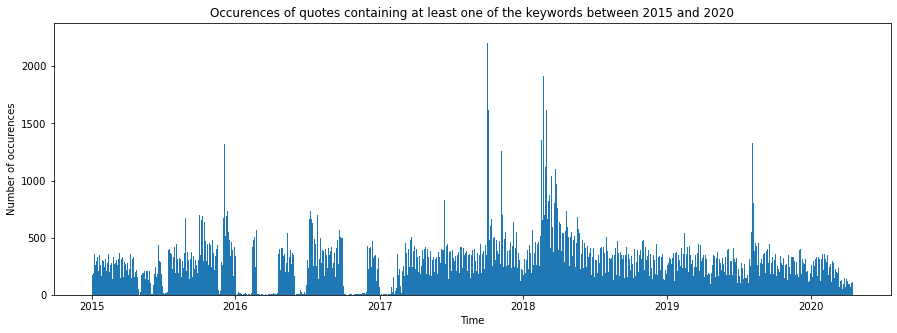

In [3]:
# Plotting number of quotes that contain keywords on the timeframe of the dataset
plt.figure(figsize=(15,5))

plt.hist(df['date'],bins=2000)

plt.title('Occurences of quotes containing at least one of the keywords between 2015 and 2020')
plt.xlabel('Time')
plt.ylabel('Number of occurences')
plt.show()

This histogram gives a good idea of how much people have been speaking of guns/firearms/shootings in the last 5 years in the media. But it has a major flaw: each quote has the same "weight" (one quote accounts for one occurence). But some quotes occure more often then others ('numOccurences' colum in the dataframe). We should take this extra information into account if we want a better view on the data.

In [11]:
# Define a new dataframe for this specific study
df = df_original[['date','numOccurrences']]
df.sample(n=15)

,date,numOccurrences
528264,2019-02-15 00:00:00,4
85714,2015-04-09 00:53:42,1
72219,2015-05-13 08:00:00,1
523283,2019-12-16 21:13:53,3
519109,2019-09-12 14:48:14,1
110465,2016-08-22 15:53:06,4
491597,2019-01-11 16:37:51,1
590446,2020-03-04 10:13:29,1
120639,2016-09-15 22:41:05,2
571207,2020-01-24 00:45:00,112


This sample shows well how some quotes can have very different number of occurences, and therefore highlights how important it is for us to take this parameter into account.

We will now define a new dataframe that contains the number of quotes (multiplied by their respective occurences) containing at least one of the keywords per day.

In [6]:
# We sum all the occurences of each date, and create a "sum" column in the dataframe
df = df['date'].dt.date.value_counts().rename('sum').to_frame()

# The dates are now the indices of the rows. We make them a column again.
df.index.name = 'date'
df.reset_index(inplace=True)

# Convert data column to datetime format, removing time
df['date'] = pd.to_datetime(df['date'])

# Sort dataframe by date
df = df.sort_values(by=['date'])

df.head(n=10)

,date,sum
1582,2015-01-01,141
1489,2015-01-02,167
1597,2015-01-03,135
1568,2015-01-04,145
1235,2015-01-05,221
1127,2015-01-06,254
517,2015-01-07,390
620,2015-01-08,367
1009,2015-01-09,292
1182,2015-01-10,236


We now have our desired dataframe: one row is one day, and for each day we have the number of quotes (multiplied by their occurences) that contain at least a keyword.

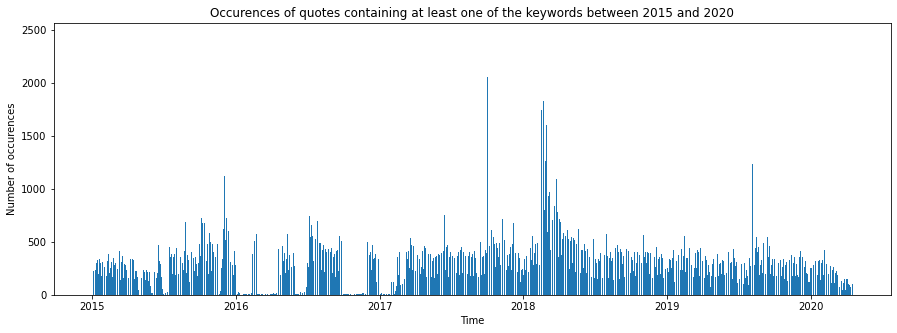

In [7]:
# Plotting number of quotes that contain keywords on the timeframe of the dataset
plt.figure(figsize=(15,5))

plt.bar(df['date'],df['sum'])

plt.title('Occurences of quotes containing at least one of the keywords between 2015 and 2020')
plt.xlabel('Time')
plt.ylabel('Number of occurences')
plt.show()

In the end, we see that this is plot is extremly similar to what we have obtained in the previous histogram! I guess this is what data science is about sometimes... At least we have cleared a possible error out of the way.

## 2 - Analysis of the "Mother Jone's" dataset

We have also proceeded to some initial analysis of the "Mother Jone's US Mass Shootings" dataset. Indeed, this dataset will give us some basic information about most shooti

In [13]:
# The csv file is read
data_folder = './Data/'
df = pd.read_csv(data_folder + 'MassShootings.csv')

# Unrelevant columns for the study are dropped
df = df.drop(columns = ['year', 'summary', 'prior_signs_mental_health_issues', 'mental_health_details', 'mental_health_sources', 'sources_additional_age', 'latitude', 'longitude'])

# Location is splited in 2 columns for better analysis
df[['town', 'state']] = df['location'].str.split(', ', expand = True)

# Mass shooting's date is converted in datetime format for better handling
df['date'] = pd.to_datetime(df['date'])

# Quotebank dataset is limited to years 2015-2021. Same time span is applied here
df = df.drop(df[df['date'].dt.year < 2015].index)

df.head()

,case,location,date,fatalities,injured,total_victims,location.1,age_of_shooter,weapons_obtained_legally,where_obtained,weapon_type,weapon_details,race,gender,sources,type,town,state
0,San Jose VTA shooting,"San Jose, California",2021-05-26,9,0,9,Workplace,57,-,-,semiautomatic handguns,-,-,M,https://www.sfchronicle.com/crime/article/Mass...,Mass,San Jose,California
1,FedEx warehouse shooting,"Indianapolis, Indiana",2021-04-15,8,7,15,Workplace,19,yes,-,semiautomatic rifle,-,White,M,https://www.indystar.com/story/news/crime/2021...,Mass,Indianapolis,Indiana
2,Orange office complex shooting,"Orange, California",2021-03-31,4,1,5,Workplace,-,-,-,semiautomatic handgun,-,-,M,https://www.latimes.com/california/story/2021-...,Mass,Orange,California
3,Boulder supermarket shooting,"Boulder, Colorado",2021-03-22,10,0,10,Workplace,21,Yes,-,"semiautomatic rifle, semiautomatic handgun; ta...",Ruger AR-556; weapon was purchased six days be...,-,M,https://www.denverpost.com/2021/03/22/police-a...,Mass,Boulder,Colorado
4,Atlanta massage parlor shootings,"Atlanta, Georgia",2021-03-16,8,1,9,Workplace,21,-,-,-,-,White,M,https://www.ajc.com/news/breaking-multiple-sho...,Spree,Atlanta,Georgia


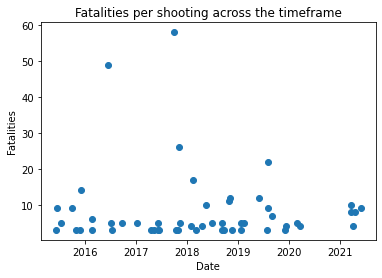

In [17]:
# ploting all shootings since 2015 according to the fatalities
plt.scatter(df['date'], df['fatalities'])
plt.title('Fatalities per shooting across the timeframe')
plt.xlabel('Date')
plt.ylabel('Fatalities')
plt.show()

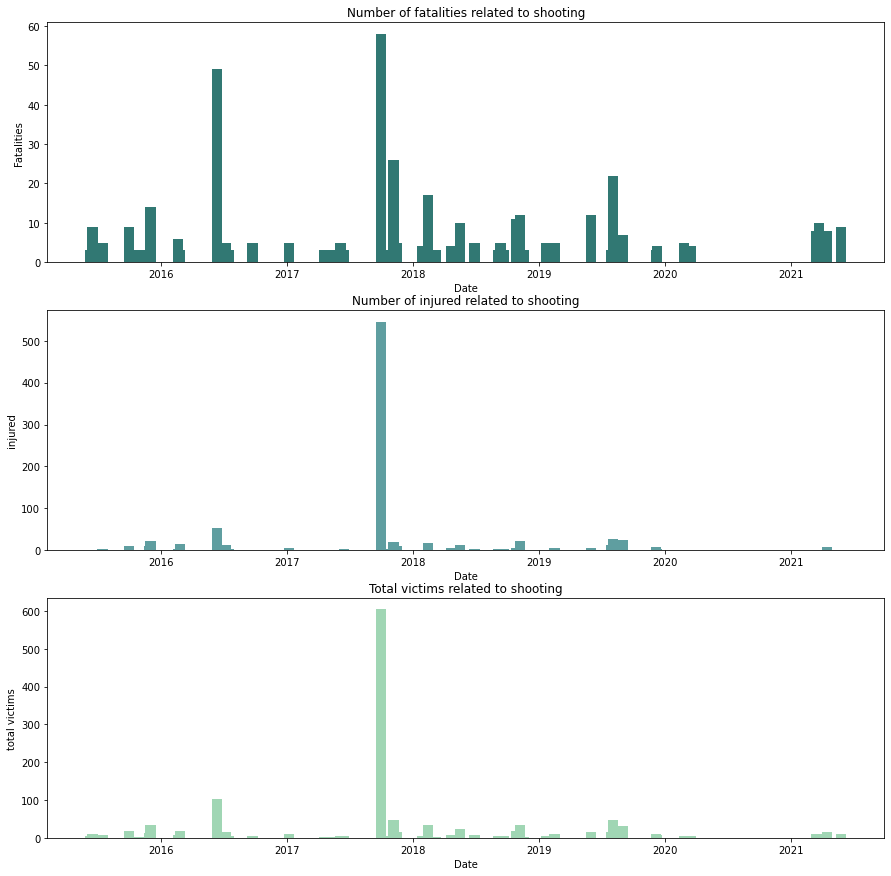

In [19]:
# The distribution of of fatalities, injured, total per month is plotted here
fig, ax = plt.subplots(3,1,figsize=(15, 15))

# Add x-axis and y-axis
ax[0].bar(df['date'], df['fatalities'], width = 30, color = '#317873') #chosing the width to be equal to a month
ax[1].bar(df['date'], df['injured'], width = 30, color = '#5f9ea0')
ax[2].bar(df['date'], df['total_victims'], width = 30,  color = '#a0d6b4')

# Set title and labels for axes
ax[0].set(xlabel="Date", ylabel="Fatalities", title="Number of fatalities related to shooting")
ax[1].set(xlabel="Date", ylabel="injured", title="Number of injured related to shooting")
ax[2].set(xlabel="Date", ylabel="total victims", title="Total victims related to shooting")

plt.show()

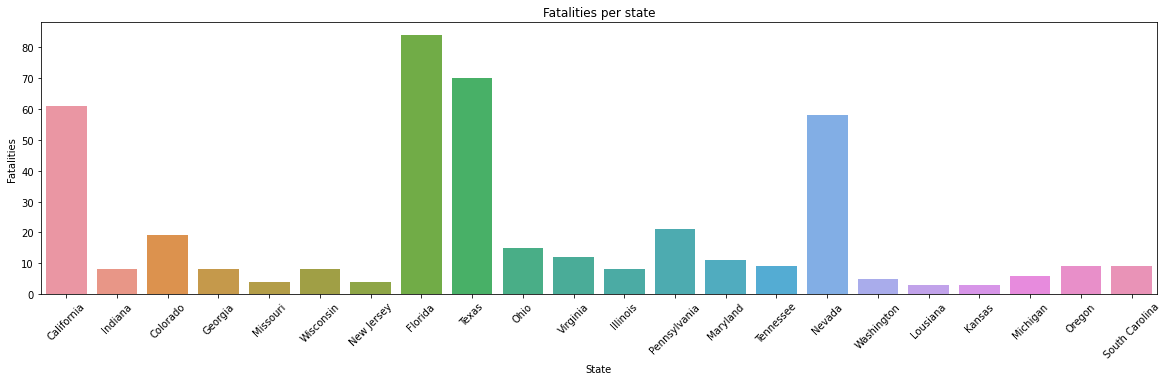

In [20]:
#ploting the number of fatalities in each state
fig, ax = plt.subplots(figsize=(20, 5))
ax = sns.barplot(y = df['fatalities'], x = df['state'], estimator = sum, ci = None)
plt.xticks(rotation=45)
ax.set(xlabel="State", ylabel="Fatalities", title="Fatalities per state")
plt.show()

In [21]:
# looking at the distribution of fatalities
df['fatalities'].describe()

count    53.000000
mean      8.207547
std      10.286957
min       3.000000
25%       3.000000
50%       5.000000
75%       9.000000
max      58.000000
Name: fatalities, dtype: float64

Text(0.5, 1.0, 'The distribution of fatalities')

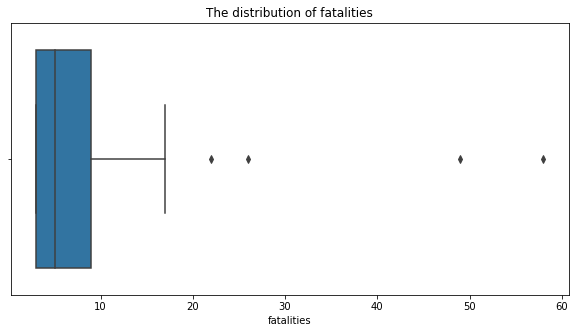

In [22]:
fig, axs = plt.subplots(1, 1, figsize=(10,5))
axs = sns.boxplot(x = df['fatalities'])
axs.set_title('The distribution of fatalities')

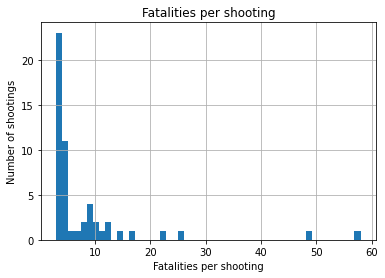

In [23]:
df['fatalities'].hist(bins= 50)
plt.xlabel('Fatalities per shooting')
plt.ylabel('Number of shootings')
plt.title('Fatalities per shooting');

! Powerlaw

LINK TO LEGAL OR NOT WEAPON => WHAT DO THE MEDIA SAY